***
# Predict Book Sales Ranking in Amazon
### First Capstone project
***
<div class="span5 alert alert-info">

<p> The main steps of this project are: </p>
<ul>
  <li> 1.Scrape and parse Amazon Book Reviews as well as the meta data.</li>
  <li> 2.Data Wrangling</li>
    <ul>
      <li> Load in and join book review to meta data</li>
      <li> Organize review texts into a sparse data frame of word counts </li>
    </ul>
   <li>3.EDA of various predictor variables and segmentation of book sales ranking </li>
   <li>4.Construct a machine learning pipeline for nested cross-validation </li>
</ul>
</div>

***


In [1]:
import os
import pandas as pd
import numpy as np
import re
import json
#from pandas.io.json import json_normalize
from collections import Counter # for counting words
from sklearn.feature_extraction.text import CountVectorizer

import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

### Load in review data, meta data and format into a data frame

In [2]:
# navigate to the folder that holds information of the files
dir_t = '/Users/yizhao/Documents/First_capstone/scraped_books'
os.chdir(dir_t)
f = []
for (dirpath, dirnames, filenames) in os.walk(os.getcwd()):
    f.extend(filenames)
    break

In [3]:
json_files = list(filter(lambda k: '.json' in k, f)) # make sure to contain only json files
print(len(json_files))

126


In [4]:
# go through the list of json files to load them into a long list of dictionaries

temp_json = [json.load((open(x))) for x in json_files]

In [5]:
complete_dat = pd.DataFrame(temp_json)
complete_dat.head() 
complete_dat.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 11 columns):
ASIN              126 non-null object
average_rating    126 non-null float64
name              126 non-null object
number_reviews    126 non-null int64
publish_date      126 non-null object
publisher         126 non-null object
rating_perc       126 non-null object
review_titles     126 non-null object
reviews           126 non-null object
sales_rank        126 non-null int64
url               126 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 10.9+ KB


In [6]:
# load in the meta file
meta_file = pd.read_csv('/Users/yizhao/Documents/First_capstone/complete_meta.csv')

meta_file.loc[:,['list_name','ASIN','review_count','title']].head()
meta_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 5 columns):
list_name       545 non-null object
review_count    545 non-null object
title           545 non-null object
url             545 non-null object
ASIN            545 non-null object
dtypes: object(5)
memory usage: 21.4+ KB


In [7]:
complete_dat.ASIN = complete_dat.ASIN.astype(str)

meta_file.ASIN = meta_file.ASIN.astype(str)


In [8]:
# join both meta file and the book revies to get list-name info

joined_data = complete_dat.merge(meta_file, on='ASIN', how='inner')


In [9]:
joined_data.review_count = joined_data.review_count.astype(str)
joined_data.review_count = joined_data['review_count'].str.replace(',','')
joined_data.review_count = joined_data.review_count.astype(int)
joined_data.head()

,ASIN,average_rating,name,number_reviews,publish_date,publisher,rating_perc,review_titles,reviews,sales_rank,url_x,list_name,review_count,title,url_y
0,0451524934,4.5,1984 (Signet Classics),5,"[January 1, 1961]",Signet Classic,"{'4 star': '17%', '3 star': '6%', '5 star': '7...","[Five Stars, Good Read!, Timely reading, Creat...","[A classic and timely~, Wonderful book. Almost...",18,https://www.amazon.com/dp/product/0451524934,lifetime,5134,1984 (Signet Classics),/gp/product-reviews/0451524934/ref=s9_acsd_al_...
1,0553380168,4.5,A Brief History of Time,1,"[September 1, 1998]",Bantam,"{'4 star': '19%', '3 star': '8%', '5 star': '6...","[Modern classic, Five Stars, Interesting Book,...",[Surprisingly accessible for the amateur/layma...,2,https://www.amazon.com/dp/product/0553380168,lifetime,1699,A Brief History of Time,/gp/product-reviews/0553380168/ref=s9_acsd_al_...
2,0375726713,4.3,A Coffin for Dimitrios,192,"[October 9, 2001]",Vintage Crime/Black Lizard,"{'4 star': '34%', '3 star': '10%', '5 star': '...","[Five Stars, Curiosity almost kills the cat, F...","[Gripping plus highly informative, Dmitrios is...",66,https://www.amazon.com/dp/product/0375726713,thriller,192,A Coffin for Dimitrios,/gp/product-reviews/0375726713/ref=s9_acsd_al_...
3,0765330342,4.6,A Dog's Purpose: A Novel for Humans,3,"[May 24, 2011]",Forge Books,"{'2 star': '1%', '3 star': '3%', '5 star': '86...","[A Must Read!, THE BEST BOOK EVER!!!!!!!!!!, A...","[Ummmm, I almost cannot fathom how the depths ...",144,https://www.amazon.com/dp/product/0765330342,best_seller,3892,A Dog's Purpose: A Novel for Humans,/gp/product-reviews/0765330342/ref=s9_acsd_al_...
4,0670026190,4.7,A Gentleman in Moscow: A Novel,1,"[September 6, 2016]",Viking,"{'2 star': '1%', '3 star': '3%', '5 star': '81...","[The best book of 2016, A missed opportunity t...","[5++ stars, A Gentleman in Moscow will stay wi...",78,https://www.amazon.com/dp/product/0670026190,best_seller,1818,A Gentleman in Moscow: A Novel,/gp/product-reviews/0670026190/ref=s9_acsd_al_...


In [10]:
# organize the rating breakups

rating_breakup = joined_data['rating_perc'].apply(pd.Series) # spread into columns
rating_breakup = rating_breakup.fillna('0%') # fill NA values with zero
rating_breakup = rating_breakup.replace('%','',regex=True).astype('float')/100 # convert into decimals

# concat to the dataframe
joined_data = pd.concat([joined_data,rating_breakup], axis=1)

### Organize review texts into data frames

In [12]:
# parse out the bag of words for both Titles and the Reviews
# start with one book
test_list = joined_data.review_titles[0]
one_string = '.'.join(test_list)
print(one_string[:50])

Five Stars.Good Read!.Timely reading.Creative and 


In [37]:
# break and then break them into a list of words
from time import time
t0 = time()
    
vec = CountVectorizer() 

data = vec.fit_transform(test_list).toarray()
vocab = vec.get_feature_names()
np.clip(data, 0, 1, out=data)
dist = np.sum(data, axis=0)

temp_dict = {}
for tag, count in zip(vocab, dist):
    temp_dict[tag] = count

print("done in %0.3fs" % (time() - t0)) #0.07
print(temp_dict)

done in 0.070s
{'thriller': 1, 'yesterday': 2, '2084': 1, 'back': 6, 'philosophical': 1, 'missed': 3, 'laughs': 1, 'brief': 1, 'recurring': 1, 'century': 9, 'require': 2, 'fi': 3, 'think': 16, 'somewhat': 4, 'fuss': 1, 'few': 3, 'important': 14, 'provide': 1, 'goodby': 1, 'anticipated': 1, 'reminder': 1, 'others': 2, '10th': 1, 'even': 14, 'unlikable': 1, 'commentary': 1, 'statement': 1, 'manages': 1, 'unrivaled': 1, 'any': 4, '2015': 2, 'manner': 1, 'anti': 2, 'opener': 1, 'doom': 1, 'we': 17, 'replacement': 1, 'delivery': 6, 'faded': 1, 'contents': 1, 'making': 1, 'becoming': 3, 'were': 1, 'not': 82, 'stuff': 2, 'double': 1, 'believe': 3, 'delight': 1, 'arms': 1, 'up': 18, 'present': 7, 'filled': 2, 'dystopic': 1, 'world': 18, 'warning': 10, 'digital': 1, 'knowledge': 1, 'while': 1, 'has': 15, 'cliff': 1, 'eerie': 6, 'eyeglasses': 1, 'but': 84, '1985': 1, 'my': 40, 'trending': 1, 'book': 301, '1948': 2, 'translation': 1, 'its': 16, 'fine': 4, 'imaginitive': 1, 'thoroughly': 1, 'below

In [40]:
# now define a function that intakes a list of strings and outputs a dictionary of word frequencies
def word_count(test_list):
    one_string = '.'.join(test_list)
    clean_string = re.sub(r'\W|\d',' ', one_string).lower() # and change to all lower cases
    # break and then break them into a list of words
    words = re.split(r'\s+', clean_string)

    # remove words that are less than 3 letters long
    filtered = [ v for v in words if len(v)>2 ]
    # get a dictionary of word occurrences
    return dict(Counter(filtered))

t0 = time()
temp_dict2 = word_count(test_list)
print("done in %0.3fs" % (time() - t0))
print(temp_dict2)

done in 0.014s
{'thriller': 1, 'yesterday': 2, 'fuss': 1, 'back': 6, 'philosophical': 1, 'missed': 3, 'laughs': 1, 'cliff': 1, 'recurring': 1, 'century': 9, 'require': 2, 'scarey': 1, 'think': 17, 'somewhat': 4, 'holding': 1, 'few': 3, 'important': 14, 'provide': 1, 'goodby': 1, 'anticipated': 1, 'sobering': 1, 'reminder': 1, 'others': 2, 'captivating': 1, 'gripping': 1, 'unlikable': 1, 'commentary': 1, 'statement': 1, 'manages': 1, 'unrivaled': 1, 'week': 1, 'science': 4, 'manner': 1, 'crime': 1, 'opener': 1, 'service': 3, 'doom': 1, 'replacement': 1, 'delivery': 6, 'faded': 1, 'iconic': 1, 'making': 1, 'becoming': 3, 'were': 1, 'not': 83, 'stuff': 2, 'double': 1, 'believe': 3, 'delight': 1, 'arms': 1, 'present': 7, 'filled': 2, 'shrugged': 1, 'world': 19, 'eye': 3, 'digital': 1, 'knowledge': 1, 'while': 1, 'prophetic': 14, 'dangers': 1, 'order': 3, 'eyeglasses': 1, 'but': 84, 'stop': 1, 'trending': 1, 'enjoy': 6, 'nightmare': 1, 'translation': 1, 'its': 16, 'fine': 4, 'imaginitive': 

In [11]:
# create a list of words that shall be excluded from the word counts
stop_word_list = ['first','second','one','two','three','four','five','star','stars','book','books','novel','read','reading',
                                   'story','stories','author','character','characters','series','writing','written','by',
                                   'be','being','is','are','was','were','be','been','and','but','for','has','have','had','does','do',
                                   'really','about','well','just','from','like','ever','will','only','over','here','there',
                                   'the','this','that','these','those','what','when','while','where','who','how','why','than','so','because',
                                   'if','although','though','yet','no','or','not','very','to','into','must','with', 'other','another',
                                  'more','many','less','much','most','lot','can','could','couldn','would','should','shouldn','did','didn',
                                   'all','they','them','their','you','your','us','he','she','our','his','her','him','am','me','my','we',
                                  'in','out','of','as','on','at','up','before','after','again','then','a','an',
                                   'too','done','don','some','any','page','still','even','through','such','its','it',
                                  'get','got','put','made','make','makes','come','comes','came','go','goes','went',
                                   'keep','keeps','kept','bit','re','ve','quite','part','never','next',
                                     'down','also','which','end','each','every','thing','things']



In [60]:
# get stop words from the vectorizer results

t0=time()
vec = CountVectorizer(stop_words= stop_word_list)  #'man','woman',

data = vec.fit_transform(test_list).toarray()
vocab = vec.get_feature_names()
np.clip(data, 0, 1, out=data)
dist = np.sum(data, axis=0)

temp_dict = {}
for tag, count in zip(vocab, dist):
    temp_dict[tag] = count

print("done in %0.3fs" % (time() - t0)) #0.052
print(temp_dict)

done in 0.060s
{'thriller': 1, 'yesterday': 2, '2084': 1, 'back': 6, 'philosophical': 1, 'missed': 3, 'laughs': 1, 'brief': 1, 'recurring': 1, 'century': 9, 'require': 2, 'fi': 3, 'think': 16, 'somewhat': 4, 'holding': 1, 'few': 3, 'important': 14, 'provide': 1, 'goodby': 1, 'anticipated': 1, 'reminder': 1, 'others': 2, '10th': 1, 'gripping': 1, 'unlikable': 1, 'commentary': 1, 'statement': 1, 'manages': 1, 'unrivaled': 1, 'week': 1, '2015': 2, 'manner': 1, 'anti': 2, 'opener': 1, 'doom': 1, 'we': 17, 'replacement': 1, 'delivery': 6, 'faded': 1, 'contents': 1, 'making': 1, 'becoming': 3, 'oie': 1, 'stuff': 2, 'double': 1, 'believe': 3, 'delight': 1, 'arms': 1, 'up': 18, 'present': 7, 'filled': 2, 'dystopic': 1, 'world': 18, 'warning': 10, 'digital': 1, 'knowledge': 1, 'cliff': 1, 'eerie': 6, 'eyeglasses': 1, '1985': 1, 'my': 40, 'prepared': 1, 'enjoy': 6, '1948': 2, 'translation': 1, 'fine': 4, 'imaginitive': 1, 'below': 1, 'eight': 2, 'ourselves': 1, 'consciousness': 1, 'questions': 1

In [12]:
# vectorize function
def dictionarize(test_list, stop_word_list):
    vec = CountVectorizer(stop_words= stop_word_list)  #'man','woman',

    data = vec.fit_transform(test_list).toarray()
    vocab = vec.get_feature_names()
    np.clip(data, 0, 1, out=data)
    dist = np.sum(data, axis=0)

    temp_dict = {}
    for tag, count in zip(vocab, dist):
        temp_dict[tag] = count
    return temp_dict

In [13]:
# Unify all books' word counts so that they have the same length of keys
# 1. get the union of all keys, 
# 2. add the missing keys in individual dictionaries

def unify_keys(L): # L is a list of dictionaries
    allkeys = frozenset().union(*L)
    for i in L:
        for j in allkeys:
            if j not in i:
                i[j]=0
    return L

### EDA of Review Title Words

In [14]:
# apply the word count function to all the books and get a list of dictionaries
titles_word_c = [dictionarize(x, stop_word_list) for x in complete_dat.review_titles]

# unify the list of review title words 
titles_word_unified = unify_keys(titles_word_c)
spread_titles = pd.Series(titles_word_unified).apply(pd.Series) 
# spread into columns with each word as a column header

spread_titles.shape 

(126, 14366)

In [15]:
spread_titles.sum().sort_values(ascending=False)[:50]
# once we have multiple book lists, 
#the words could be grouped by the book list first before summing their occurrences

great           12232
good             6707
love             4098
loved            3301
excellent        2747
best             2689
classic          2571
wonderful        2274
amazing          1864
favorite         1607
time             1542
life             1433
interesting      1314
funny            1310
fun              1305
enjoyed          1274
awesome          1265
beautiful         980
little            958
better            908
history           895
man               863
worth             798
easy              795
ove               787
thought           778
fantastic         755
recommend         754
old               722
enjoyable         614
dog               612
perfect           597
way               589
gift              585
entertaining      581
highly            566
children          562
review            557
writing           541
wow               540
long              534
new               528
movie             518
nice              510
american          493
always    

In [16]:
word_counts = list(spread_titles.sum())
word_counts[:5]

[1, 3, 1, 1, 1]

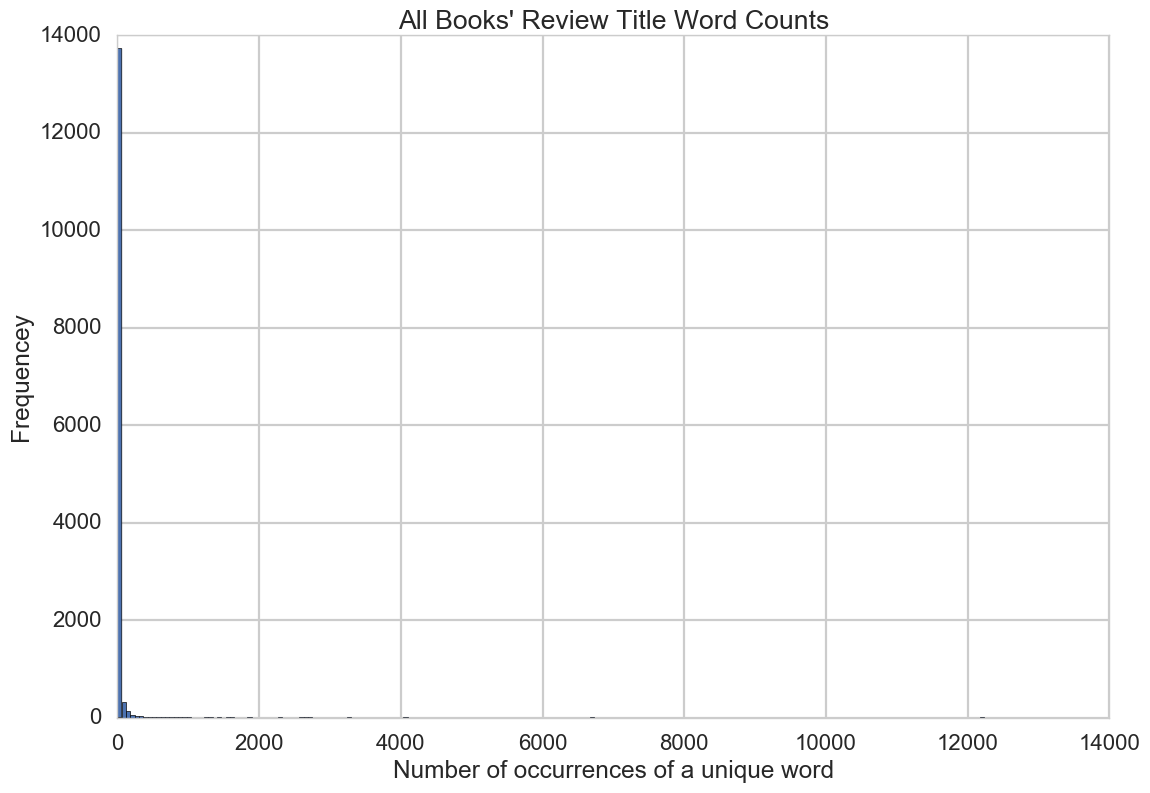

In [17]:
#plot histogram of the word count distribution to find a cutoff point
plt.hist(word_counts,bins=200)
plt.title("All Books' Review Title Word Counts")
plt.xlabel("Number of occurrences of a unique word")
plt.ylabel("Frequencey")
plt.show()

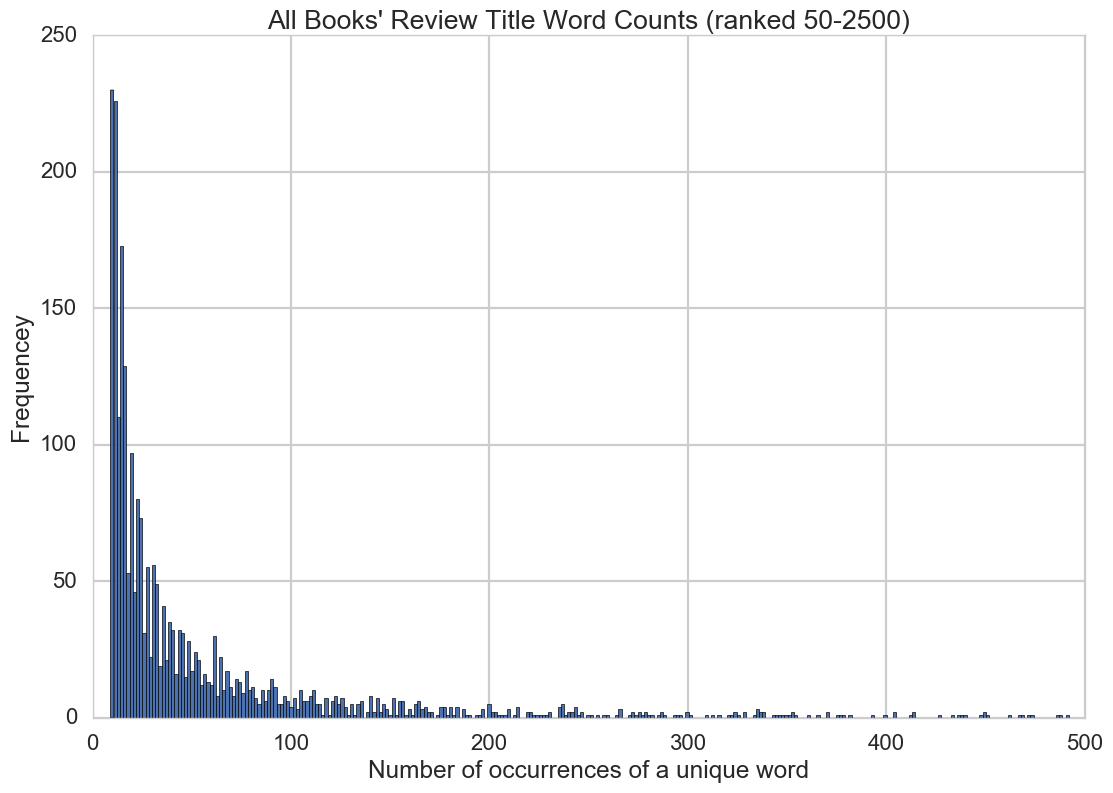

In [100]:
#plot histogram of the word count for not the highest and not the lowest occurence words
plt.hist(list(spread_titles.sum().sort_values(ascending=False)[50:2500]),bins=300)
plt.title("All Books' Review Title Word Counts (ranked 50-2500)")
plt.xlabel("Number of occurrences of a unique word")
plt.ylabel("Frequencey")
plt.show()

### EDA of Review Text Words

In [18]:
# apply the word count function to all the books and get a list of dictionaries
review_word_c = [dictionarize(x, stop_word_list) for x in complete_dat.reviews]

# unify the list of review  words 
review_word_unified = unify_keys(review_word_c)
spread_reviews = pd.Series(review_word_unified).apply(pd.Series) 
# spread into columns with each word as a column header

spread_reviews.shape 

(126, 48269)

In [19]:
spread_reviews.sum().sort_values(ascending=False)[:50]

great          25327
good           17369
love           15612
time           12594
loved          12249
life           11737
recommend       8428
enjoyed         8255
way             8191
interesting     7463
people          7293
best            6983
little          6880
think           6389
know            6229
excellent       5734
wonderful       5691
now             5470
writing         5407
old             5373
thought         5344
see             4917
times           4885
years           4816
found           4758
better          4579
classic         4569
history         4563
want            4548
man             4524
favorite        4507
always          4481
highly          4437
hard            4432
world           4309
funny           4123
amazing         4082
long            4054
new             4019
easy            3999
children        3800
movie           3799
find            3787
anyone          3786
enjoy           3770
family          3767
real            3675
year         

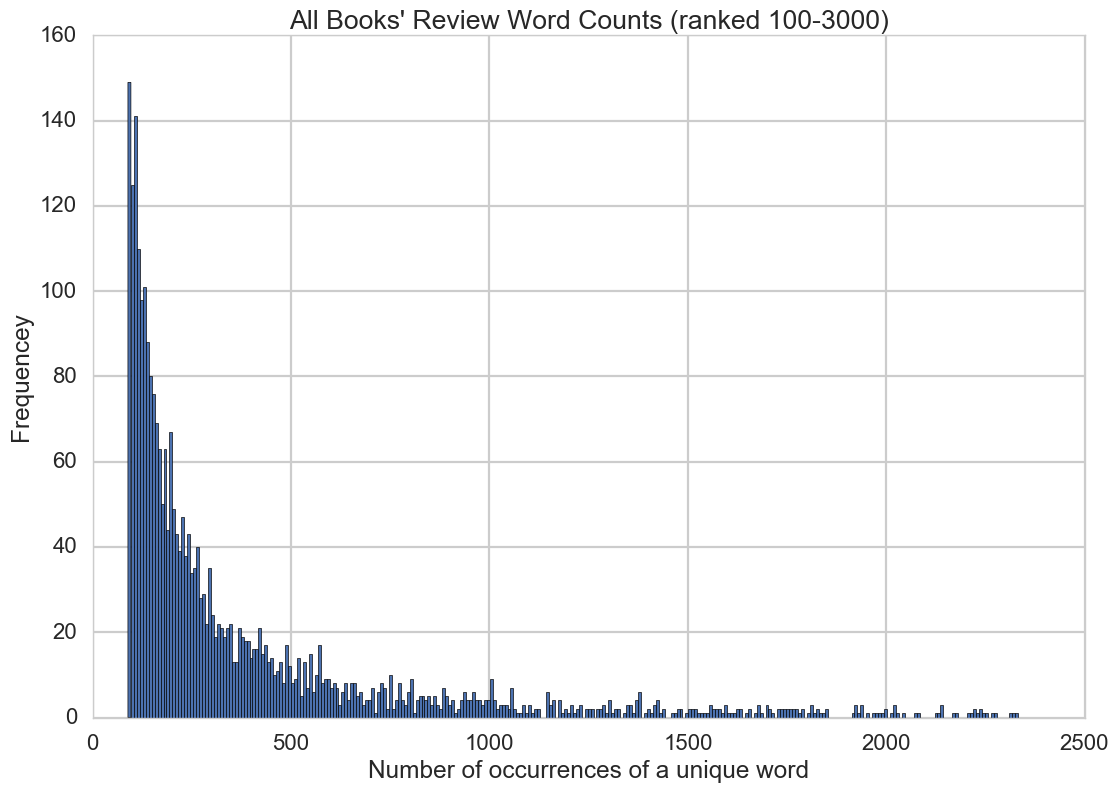

In [162]:
#plot histogram of the word count for not the highest and not the lowest occurence words
plt.hist(list(spread_reviews.sum().sort_values(ascending=False)[100:3000]),bins=300)
plt.title("All Books' Review Word Counts (ranked 100-3000)")
plt.xlabel("Number of occurrences of a unique word")
plt.ylabel("Frequencey")
plt.show()

## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [113]:
joined_data.describe()

,average_rating,number_reviews,sales_rank,review_count,1 star,2 star,3 star,4 star,5 star
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,4.503175,221.619048,130.412698,1796.190476,0.039524,0.039444,0.076190,0.181825,0.663016
std,0.133229,275.676763,215.487699,2830.492457,0.036636,0.028123,0.041758,0.073999,0.139216
min,4.300000,1.000000,1.000000,21.000000,0.000000,0.000000,0.010000,0.040000,0.320000
25%,4.400000,2.000000,4.250000,292.000000,0.012500,0.020000,0.040000,0.130000,0.550000
50%,4.500000,98.500000,21.000000,801.500000,0.030000,0.030000,0.075000,0.180000,0.660000
75%,4.600000,369.000000,141.000000,2056.500000,0.050000,0.050000,0.100000,0.227500,0.780000
max,4.700000,958.000000,876.000000,15755.000000,0.210000,0.140000,0.200000,0.400000,0.940000


It seems that sales rank has a high range, in that the standard deviation is about 50% higher than the mean. 
The total number of reviews also has a wide range from 21 to 15,755. 
In contrast, the average rating has a relatively small range, and the std is less than 3% of the mean. We probably could not expect much variation in sales rank explained by the average review ratings.However, the by category review rating percentage from 1 star to 5 star may provide more information.

To have a better understanding of the relationships across those variables, let's compute a correlation matrix.


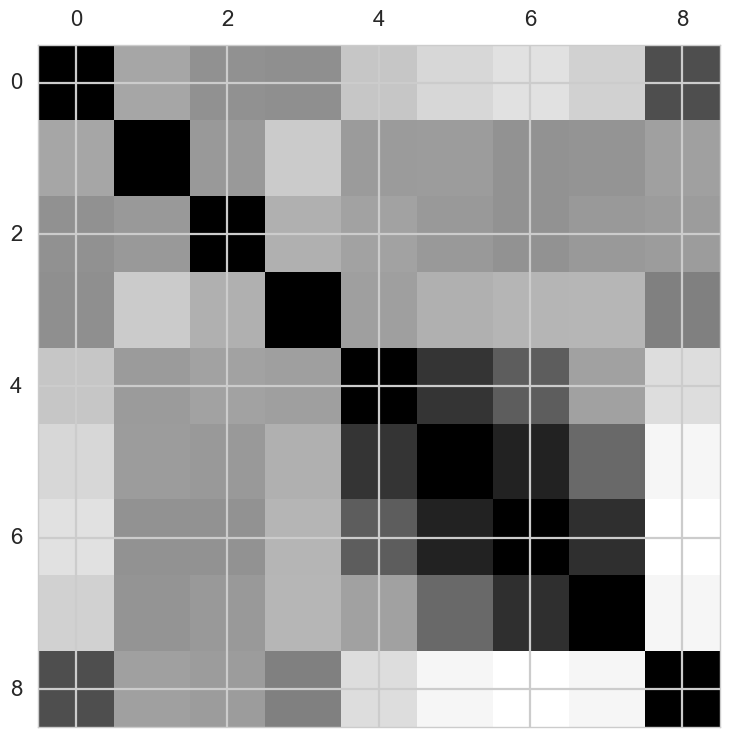

In [118]:
plt.matshow(joined_data.corr())
plt.show()

The highest correlations are between '1 star' and '2 star', '2 star' and '3 star', '3 star' and '4 star', and 'average_rating' and '5 star'. Those are built in mechanism in the data itself. We would expect various components of review ratings would be highly correlated with each other. It will be important to prevent from choosing more than 2 out of those 6 predictor variables later on to reduce the amount of collinearity. 

Our dependent variable, sales rank, seems to be the most correlated with average rating and '3 star' rating percentage. And the correlation between average rating and '3 star' is actually the lowest among all pairs that include the average rating. 



### Sales rank histogram/ violin plot

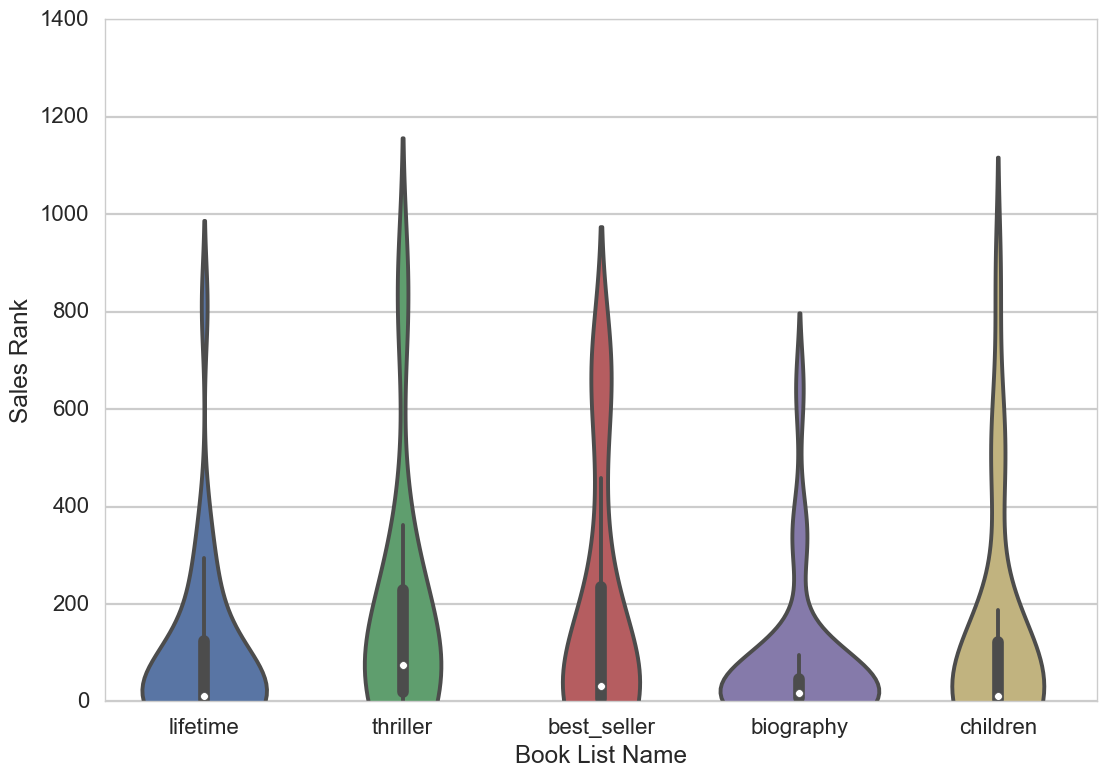

In [157]:
joined_data.list_name = joined_data.list_name.astype(str)
violin = sns.violinplot(y=joined_data.sales_rank, data= joined_data, x= joined_data.list_name)
axes = violin.axes

violin.set(xlabel= 'Book List Name', ylabel= 'Sales Rank')
axes.set_ylim(0,)
plt.show()

It seems that all book lists are highly skewed toward zero. Biography and lifetime must read are the two most severely skewed book lists. 

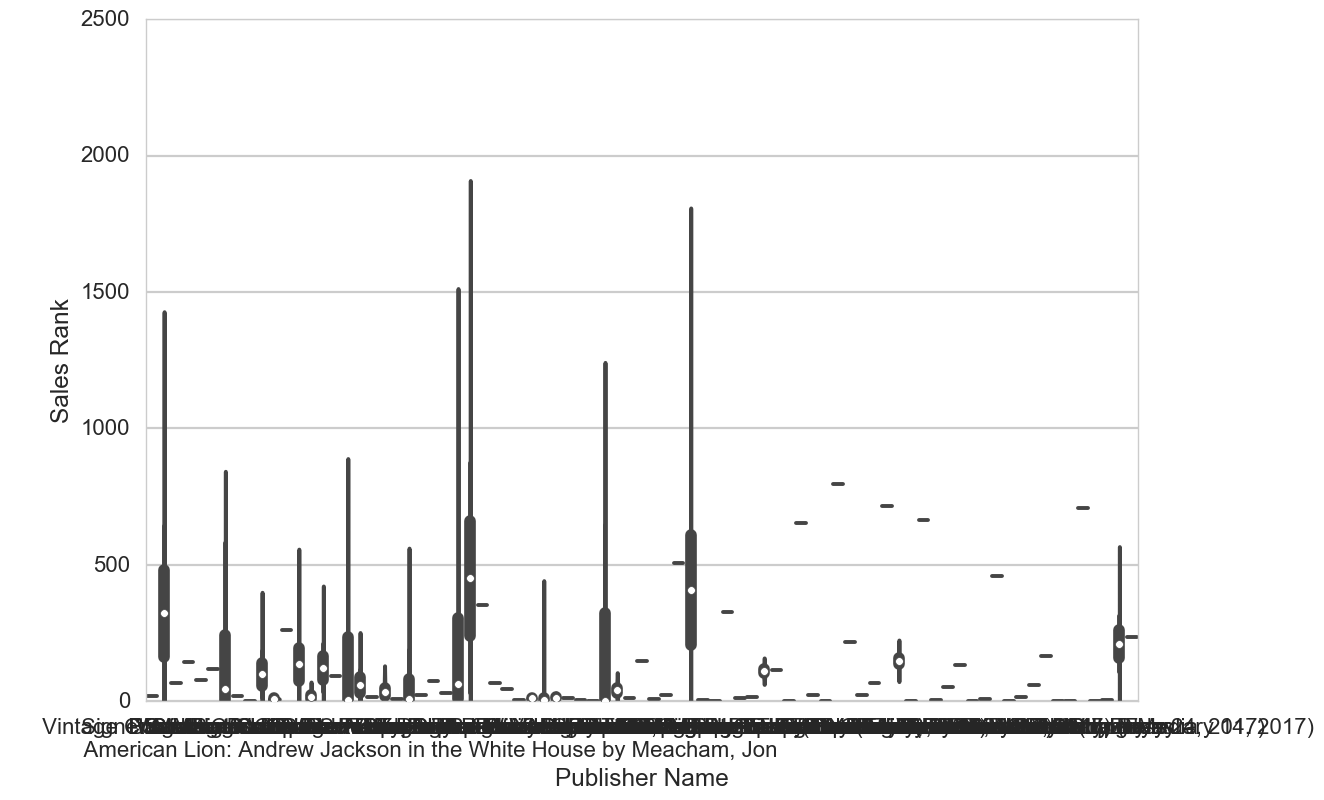

In [21]:
violin = sns.violinplot(y=joined_data.sales_rank, data= joined_data, x= joined_data.publisher)
axes = violin.axes

violin.set(xlabel= 'Publisher Name', ylabel= 'Sales Rank')
axes.set_ylim(0,)
plt.show()

There doesn't seem to be any publisher that stood out as significantly better ranking.

### Scatterplots
***

Let's look at some scatter plots for three variables: 'number_reviews', 'average_rating' and '3 star' .  

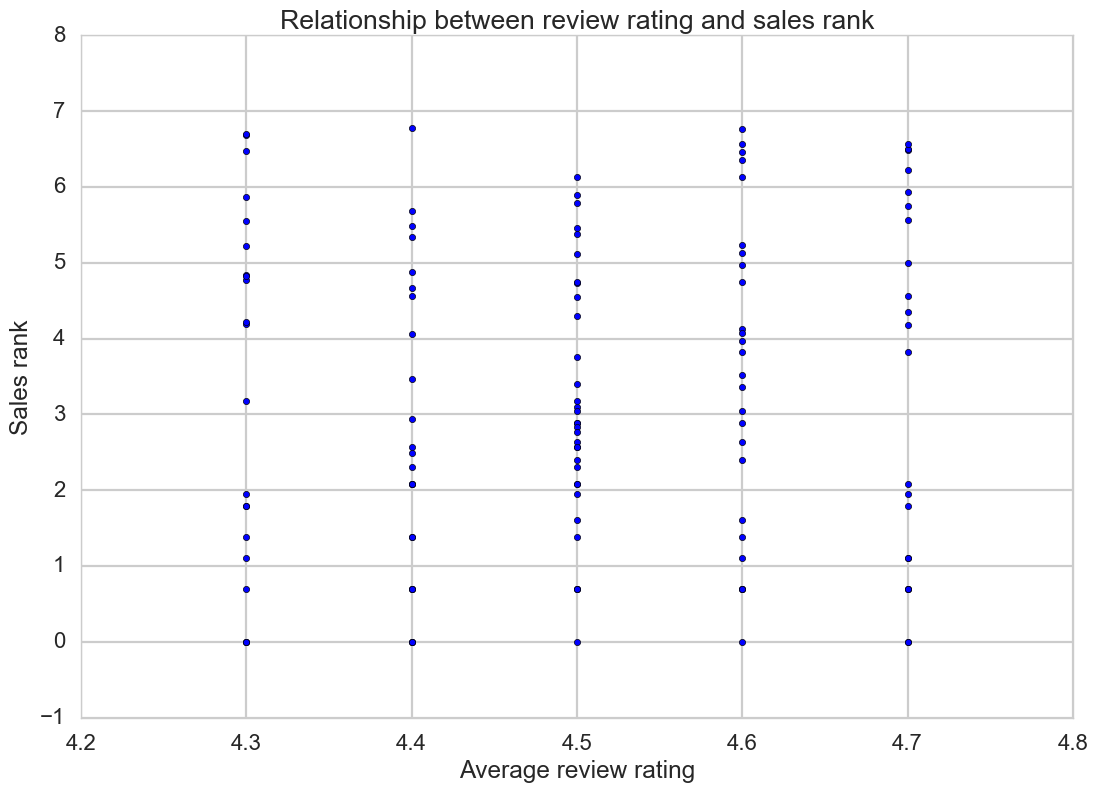

In [145]:
plt.scatter(joined_data.average_rating, np.log(joined_data.sales_rank))
plt.xlabel("Average review rating")
plt.ylabel("Sales rank")
plt.title("Relationship between review rating and sales rank")
plt.show()

The average review rating seems to be not so continuous, mostly because it was rounded to one decimal place in Amazon when being scraped.

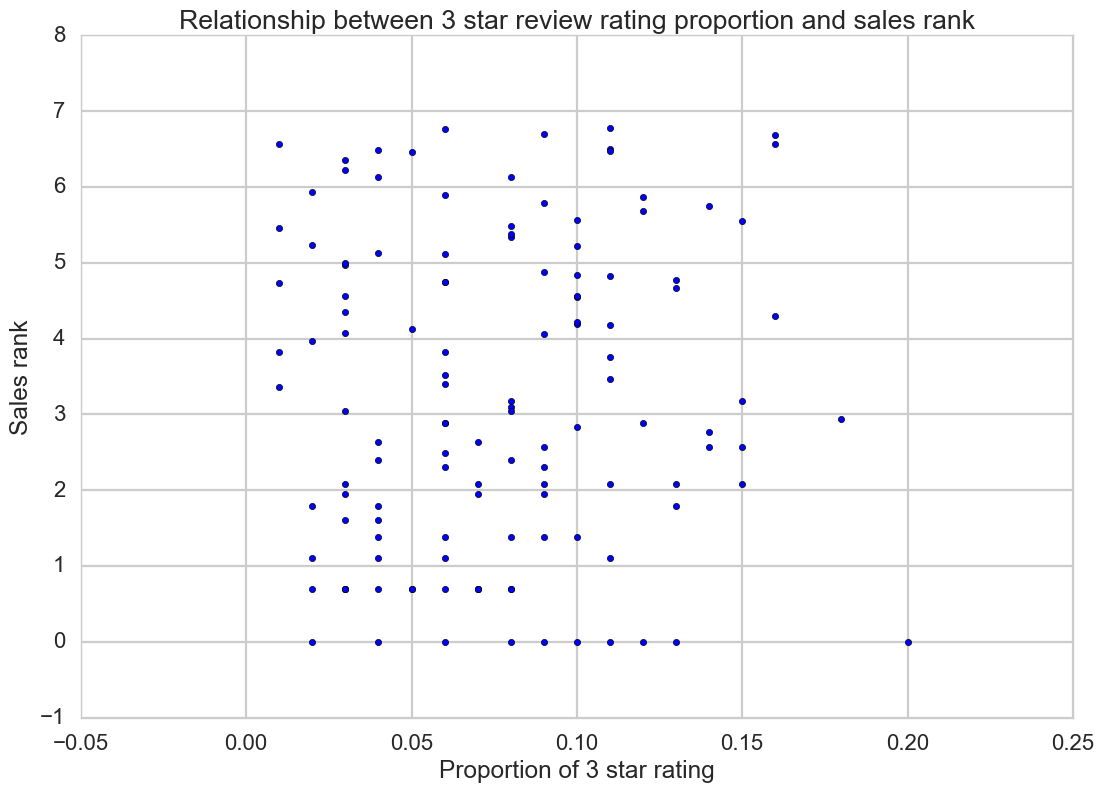

In [144]:
plt.scatter(joined_data['3 star'], np.log(joined_data.sales_rank))
plt.xlabel("Proportion of 3 star rating")
plt.ylabel("Sales rank")
plt.title("Relationship between 3 star review rating proportion and sales rank")
plt.show()

There doesn't appear to be any significant relationship from looking at this scatter plot.

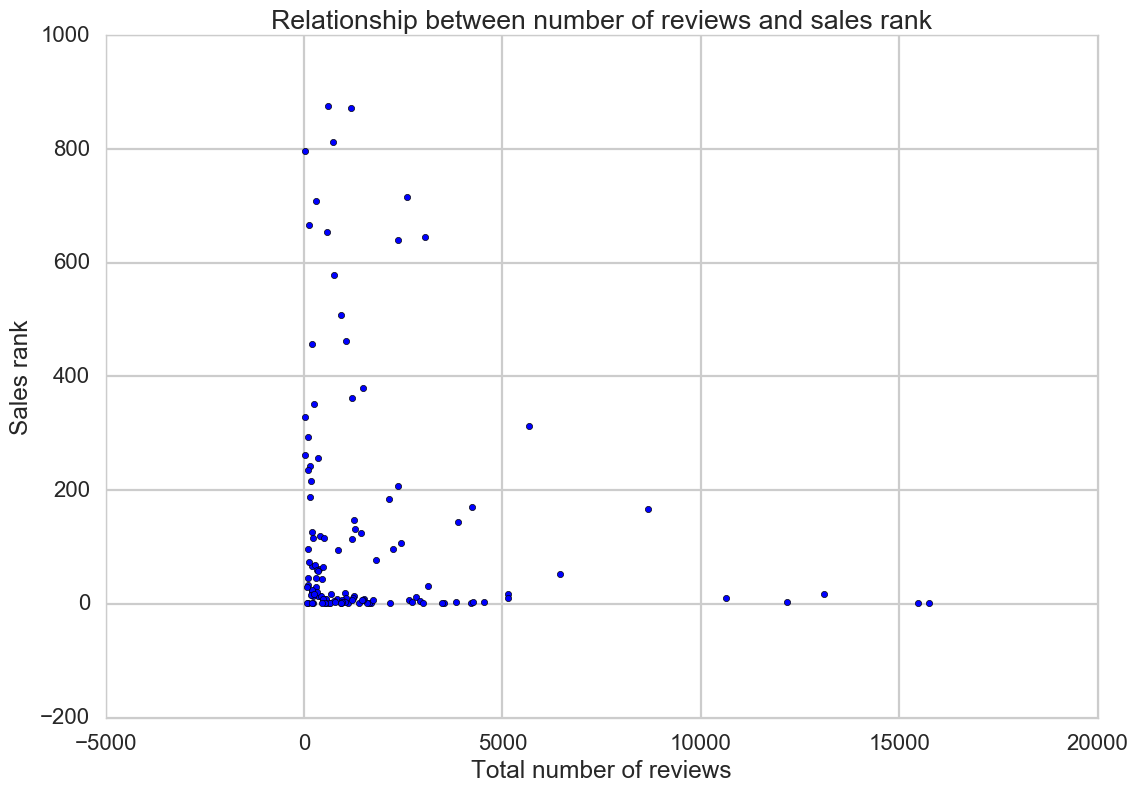

In [124]:
plt.scatter(joined_data.review_count, joined_data.sales_rank)
plt.xlabel("Total number of reviews")
plt.ylabel("Sales rank")
plt.title("Relationship between number of reviews and sales rank")
plt.show()

For books below a rank of 100, there is a wide range of of total number of reviews.
Overall, there appears to be a negative exponential relationship between the two. 
If we use a log transform of the total reviews, a negative linear pattern may surface.

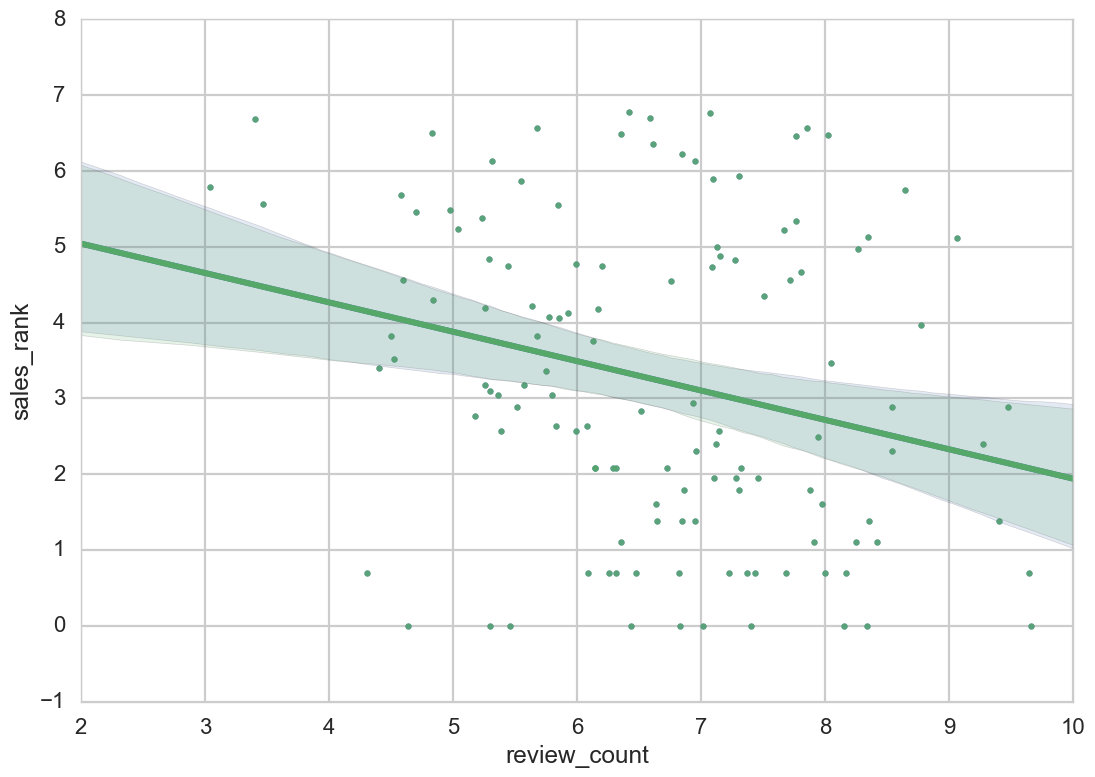

In [147]:

sns.regplot(y=np.log(joined_data.sales_rank), x=np.log(joined_data.review_count), data=joined_data, fit_reg = True)
plt.show()

Indeed, there appears to be a much stronger linear relationship once both the number of reviews and the sales rank is log transformed.

### Fitting Linear Regression using `statsmodels`
***

In [148]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [28]:
# apply linear regression on the predictor variables that appear to be related with sales rank
joined_data['log_salesRank'] = np.log(joined_data.sales_rank)
joined_data['log_reviewCount'] = np.log(joined_data.review_count)
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 125
Data columns (total 22 columns):
ASIN               126 non-null object
average_rating     126 non-null float64
name               126 non-null object
number_reviews     126 non-null int64
publish_date       126 non-null object
publisher          126 non-null object
rating_perc        126 non-null object
review_titles      126 non-null object
reviews            126 non-null object
sales_rank         126 non-null int64
url_x              126 non-null object
list_name          126 non-null object
review_count       126 non-null int64
title              126 non-null object
url_y              126 non-null object
1 star             126 non-null float64
2 star             126 non-null float64
3 star             126 non-null float64
4 star             126 non-null float64
5 star             126 non-null float64
log_salesRank      126 non-null float64
log_reviewCount    126 non-null float64
dtypes: float64(8), int64(3), ob

In [155]:
m = ols('log_salesRank ~ log_reviewCount + list_name + average_rating', joined_data).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:          log_salesRank   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.108
Date:                Thu, 09 Mar 2017   Prob (F-statistic):             0.0573
Time:                        20:54:52   Log-Likelihood:                -262.75
No. Observations:                 126   AIC:                             539.5
Df Residuals:                     119   BIC:                             559.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  0

In [156]:
m = ols('log_salesRank ~ log_reviewCount ', joined_data).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:          log_salesRank   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     8.692
Date:                Thu, 09 Mar 2017   Prob (F-statistic):            0.00382
Time:                        20:57:36   Log-Likelihood:                -264.85
No. Observations:                 126   AIC:                             533.7
Df Residuals:                     124   BIC:                             539.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           5.8186      0.892     

It seems that the log_reviewCount is the only variable that is statistically significant to sales rank. 
From the scatter plots shown earlier, it's not surprising that none of the review rating scores were significant to sales rank.
Also, the violin plot of sales rank across book lists earlier showed no significant difference in means, which explains why book_list isn't a significant variable either.

Over all, the higher the total number of reviews, the better the ranking is.
The coefficient says that for every 1% increase in the number of reviews, the sales rank moves up by 0.388%.
This may be explained by the fact that the more sales a book has, the more people there are to become potential reviewers of the book. 

### Relationship between number of book reviews and the word counts

In [45]:
# subset the review count data frame to the top 2000 frequent words
def slice_freq(spread_reviews, n_top):
    
    higest_words = spread_reviews.sum().sort_values(ascending=False)[:n_top]
    
    return spread_reviews[higest_words.index]

In [41]:
# first create a new data frame that combines review word counts and the other numeric predictor variables
reviews_dat = slice_freq(spread_reviews, 10).append(
    joined_data[['average_rating', 
                 '1 star','2 star', '3 star', '4 star', '5 star',
                 'log_salesRank', 'log_reviewCount']])


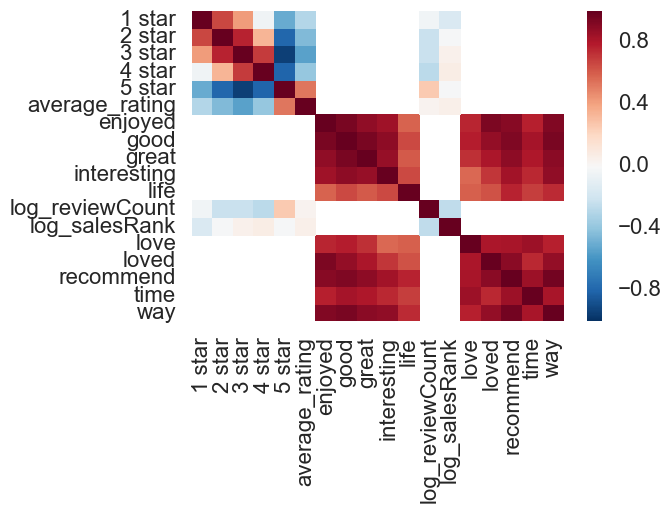

In [42]:
# plot a correlation matrix to visualize the relationship between most occured words and other predictor variables

corr_matrix = reviews_dat.corr()
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

There appears to be high correlations among the word counts, but they are not related with the review count or sales rank at all.

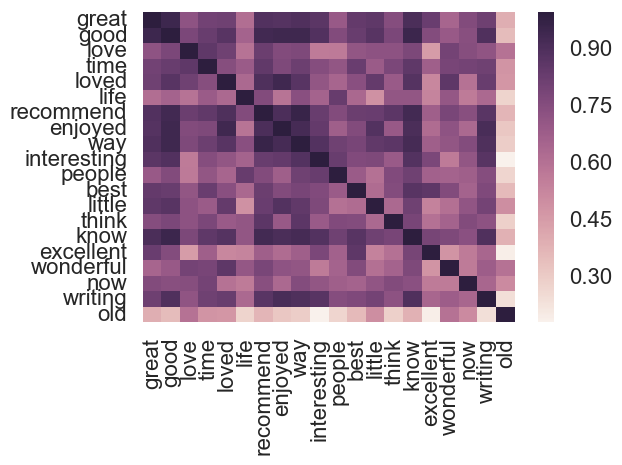

In [49]:
# visualize the correlation among most occured words 

corr_matrix = slice_freq(spread_reviews,20).corr()
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

'old' is the only word that isn't quite correlated with the others. 
The rest of the words are highly correlated with each other.

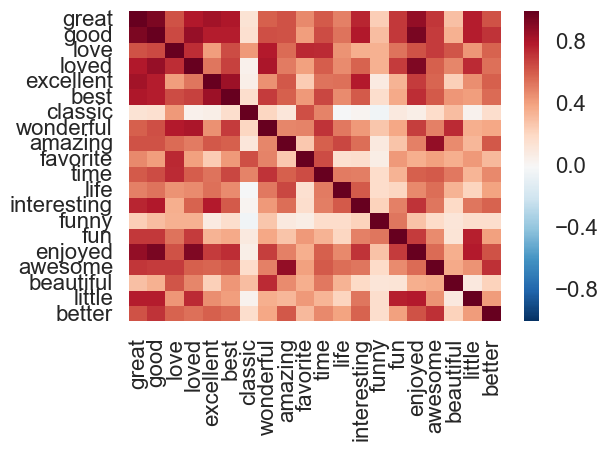

In [50]:
# compare to the correlation among most occured title words 

corr_matrix = slice_freq(spread_titles,20).corr()
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

'Classic' and 'Funny' are not as correlated with the other words, while 'great' and 'good' are the most correlated with the rest of the words.